# GenAI Use Case - A Tool for Insightful Analysis of E-Commerce Products Reviews  

###*Andrea C. Fontalvo Echavez*

The following use case presents a tool for analysis of product reviews from the [Women’s E-Commerce Clothing Reviews dataset](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews) from Kaggle. The objective of this tool is to transform unstructured customer feedback into concrete insights for product stakeholders decision making processes.

The dataset contains real, anonymized customer reviews. The tool analyzes a sample of reviews for a specific product. First, a sentiment analysis is performed to determine overall positive or negative feedback using a pre-trained binary classification model from [Hugging Face](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english). Next, pros and cons are extracted from the reviews associated with a selected product using a chunk-based analysis approach. Finally, all unique insights are aggregated to produce an overall evaluation, along with recommendations and potential product improvements. Through the Amazon Bedrock API, an LLM is used as the inference engine in a text-only setup, leveraging the [Amazon Nova Micro](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-nova.html) model. The following diagram shows the main stages of the tool's logic.

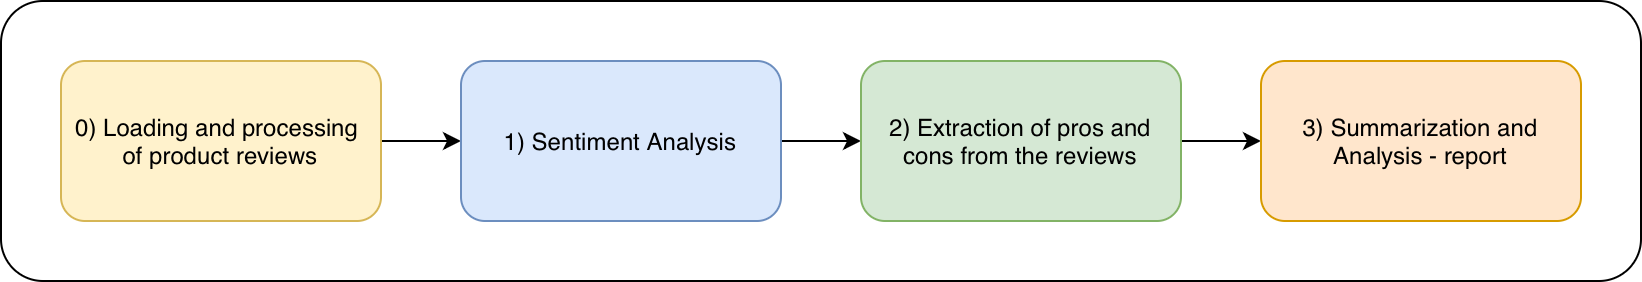

## 0) Loading and processing of product reviews

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import json
import requests
import re
from IPython.display import display, Markdown

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Environment variable for Bedrock API Key
dotenv_path = f"/content/drive/MyDrive/METYIS/key.env"
load_dotenv(dotenv_path)
BEDROCK_API_KEY = os.environ.get("BEDROCK_API_KEY")

BEDROCK_URL = "https://bedrock-runtime.us-east-1.amazonaws.com/model/amazon.nova-micro-v1:0/invoke"

# Dataset
filename = "Womens-Clothing-E-Commerce-Reviews.csv"
file_path = f"/content/drive/MyDrive/METYIS/{filename}"
reviews_df = pd.read_csv(file_path)
reviews_df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


###Clean data

In [ ]:
# Filtering of N/A reviews. Reseting of the dataframe index.
reviews_df_clean = reviews_df.dropna(subset=["Review Text"]).reset_index(drop=True)

In [ ]:
# Inspection of data
categorical_cols = ['Class Name', 'Department Name', 'Division Name','Clothing ID']

for col in categorical_cols:
    print(f"{col}: {reviews_df_clean[col].nunique()} categories")
    print("Categories:", reviews_df_clean[col].unique())
    print("")

Class Name: 20 categories
Categories: ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' nan 'Casual bottoms' 'Chemises']

Department Name: 6 categories
Categories: ['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend' nan]

Division Name: 3 categories
Categories: ['Initmates' 'General' 'General Petite' nan]

Clothing ID: 1179 categories
Categories: [ 767 1080 1077 ...  181  721  522]



In [ ]:
# Inspection of clothing IDs
reviews_df_clean['Clothing ID'].value_counts()[0:10]

,count
Clothing ID,
1078,987
862,778
1094,735
1081,561
872,519
829,512
1110,471
868,414
895,384


In [ ]:
# Filtering by Clothing ID. Selection of reviews related to a single product

CLOTHING_ID = 1110
SAMPLE_NUM = 300

reviews_df_single_product = reviews_df_clean[reviews_df_clean['Clothing ID'] == CLOTHING_ID]

# Selection of samples with a random seed for replicability
reviews_df_sample = reviews_df_single_product.sample(SAMPLE_NUM, random_state=23).reset_index(drop=True)

# Convert reviews text to a list
reviews = reviews_df_sample["Review Text"].tolist()

In [ ]:
# Inspection of the first 5 reviews
reviews[0:5]

["This dress was a 'maybe' for me online but when i tried it on i was totally won over! i got the raspberry, which is a really pretty color. i have 34dd chest and it fits nicely on me, fairly true to size and is super flattering on me- more so than most swing dresses. love it.",
 'Love this dress. very comfortable and stylish. wanted my size. but they only had a size larger available. still bought it, but feel good in it. glad i purchased it.',
 'This is just adorable on. i go between a small and medium and the small was perfect for me.. i wore this with tights and boots, but can also see this working in warmer weather with sandals or peep-toe booties.',
 'Found this dress at my local retailer. . it was one of those dresses that just catches your eye.. very,very, beautiful print. . the dress is loose and flowy and feels so comfortable on. i purchased it without a second thought. i am 5\'1" and usually wear a 0 or 2 and the 2 was a better fit for me. so breezy and cool for summer.',
 "I

## 1) Sentiment Analysis

In this first stage a pre-trained DistilBERT sentiment analysis model is used to classify customer reviews into positive or negative sentiment, providing an overall sentiment signal as context for the following stages.


In [ ]:
# Downloading the model
from transformers import pipeline

sentiment_analysis_pipeline = pipeline(
    task="sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Sentiment classification
sentiment_results = sentiment_analysis_pipeline(reviews,batch_size=32)
sentiment_df = pd.DataFrame(sentiment_results)

In [ ]:
sentiment_df.head()

,label,score
0,POSITIVE,0.999812
1,POSITIVE,0.999776
2,POSITIVE,0.999174
3,POSITIVE,0.999689
4,POSITIVE,0.999030


In [ ]:
# Calculation of sentiment distribution (%)
counts = sentiment_df['label'].value_counts()
positive_rate = np.round(counts["POSITIVE"]/SAMPLE_NUM * 100)
negative_rate = 100 - positive_rate

In [ ]:
# Preparation of dataframe for the following stage (review text + sentiment)
reviews_sentiment_analysis = pd.DataFrame({
    "Review Text": reviews_df_sample["Review Text"],
    "Sentiment": sentiment_df["label"]
})

In [ ]:
reviews_sentiment_analysis.head()

,Review Text,Sentiment
0,This dress was a 'maybe' for me online but whe...,POSITIVE
1,Love this dress. very comfortable and stylish....,POSITIVE
2,This is just adorable on. i go between a small...,POSITIVE
3,Found this dress at my local retailer. . it wa...,POSITIVE
4,I bought my usual size medium and it's huge on...,POSITIVE


## 2) Extraction of Pros and Cons

In this stage, an LLM is used to extract the most relevant pros and cons from a large set of product reviews, turning customer feedback into a structured summary for a specific product. The Amazon Bedrock API with the Amazon Nova Micro model is used, guided by a dedicated system prompt.

In [ ]:
# Chunk definitions
chunk_size = 10

review_chunks = []
start_index = 0

while start_index < len(reviews_sentiment_analysis):
    end_index = start_index + chunk_size
    review_chunks.append(reviews_sentiment_analysis.iloc[start_index:end_index].copy())
    start_index = end_index

In [ ]:
# System prompt for EXTRACTION
system_prompt_extraction = """You extract pros and cons from a group of product reviews.
Return ONLY valid JSON with keys: pros, cons.

KEYS:
- pros: list of short, specific positive claims mentioned in the reviews
- cons: list of short, specific negative claims mentioned in the reviews

RULES:
- Use ONLY information present in the reviews.
- Keep each item short and specific (one idea per item).
- Do not create multiple items that say the same thing in different words.
- Remove near-duplicates within the output.
- Do not mention review numbers in the output.
- LIMITS: pros max 8 items, cons max 8 items.
"""

In [ ]:
# Function to create prompt per review chunks

def create_prompt_extraction(chunk_dataframe):
    chunk_dataframe = chunk_dataframe.reset_index(drop=True)

    blocks = []
    for index, row in chunk_dataframe.iterrows():
        sentiment = str(row.get("Sentiment", "")).strip()
        text = str(row.get("Review Text", "")).strip()

        blocks.append(
            f"[{index}] Sentiment={sentiment}\n"
            f"Review: {text}\n"
        )

    reviews_text = "-".join(blocks)
    return  "\nREVIEWS:" + reviews_text


In [ ]:
# Function to call LLM through BEDROCK API for extraction of pros and cons

def bedrock_api_call_extraction(system_prompt,prompt,temperature,max_tokens):

  payload = {
      "messages": [{
          'role': "user",
          'content':[{
              "text": f"{prompt}" }]
          }],
      "system": [{
          "text": system_prompt
      }],
     "inferenceConfig":{
        'maxTokens': max_tokens,
        'temperature': temperature
      }
  }

  headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {BEDROCK_API_KEY}"
  }

  response = requests.request("POST",BEDROCK_URL, json=payload, headers=headers)
  raw_data = response.json()

  # Extract the raw text
  raw_text = raw_data["output"]["message"]["content"][0]["text"]

  # Remove extra json tags and elements from generated answer
  json_text = re.sub(r"^```json\s*|\s*```$", "", raw_text, flags=re.DOTALL)

  # Parse JSON text into Python dictionary
  data = json.loads(json_text)

  return data

In [ ]:
# BEDROCK API CALL to extract pros and cons

results = []
chunk_id = 0

print("Analysing review chunks:")
for chunk in review_chunks:

  print(chunk_id, end=", ")
  user_prompt = create_prompt_extraction(chunk)

  #use of system prompt + user prompt
  raw_output = bedrock_api_call_extraction(system_prompt_extraction,user_prompt,temperature=0.5,max_tokens=400)
  chunk_id += 1

  results.append(raw_output)

Analysing review chunks:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

## 3) Review summarization

In this final stage, all previously extracted insights are consolidated to generate a product review summary. The pros, cons, and sentiment signals are analyzed together to produce an assessment of customer feedback, along with recommendations.

In [ ]:
# Combination of pros and cons into a dictionary
merged = {
    "pros": [],
    "cons": []
}

for r in results:
    merged["pros"].extend(r.get("pros", []))
    merged["cons"].extend(r.get("cons", []))

In [ ]:
print("pros: ",merged["pros"][0:4])
print("cons: ",merged["cons"][0:4])

pros:  ['Pretty raspberry color', 'Fits 34dd chest nicely', 'Flattering on the wearer', 'Comfortable and stylish']
cons:  ['Bodice and skirt sizing mismatch', 'Puckers at the back with a size 4 top', 'Atrociously long in the torso with a size 6 top', 'bottom not lined like top']


In [ ]:
system_prompt_summarization = """ You are a clothing products review analyser.
From a lists of pros and cons extracted from a group of reviews of a single
product, make a summarized analysis of what people are saying to know what
needs attention.

Always answer with 3 sections: Pros, Cons and Recommendations.
"""

In [ ]:
# Function to call LLM through BEDROCK API for final summary

def bedrock_api_call_summary(system_prompt,user_prompt,temperature,max_tokens):

  payload = {
      "messages": [{
          'role': "user",
          'content':[{
              "text": f"{user_prompt}" }]
          }],
      "system": [{
          "text": system_prompt
      }],
     "inferenceConfig":{
        'maxTokens': max_tokens,
        'temperature': temperature
      }
  }

  headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {BEDROCK_API_KEY}"
  }

  response = requests.request("POST",BEDROCK_URL, json=payload, headers=headers)
  raw_data = response.json()

  # Extract the raw text
  raw_text = raw_data["output"]["message"]["content"][0]["text"]
  return raw_text

In [ ]:
# Call of the API for final summarization and report
raw_output = bedrock_api_call_summary(system_prompt_summarization,f"{merged}",temperature=0.2,max_tokens=1500)

In [ ]:
# Generation of report from output

display(Markdown(f"""
# Review Analysis for product with ID {CLOTHING_ID}
### Overall Sentiment perception:
- Positive Reviews Percentage: {positive_rate}%
- Negative Reviews Percentage: {negative_rate}%
{raw_output}"""))


# Review Analysis for product with ID 1110
### Overall Sentiment perception:
- Positive Reviews Percentage: 74.0%
- Negative Reviews Percentage: 26.0%
### Pros

1. **Design and Aesthetics**: Many reviews highlight the beautiful and unique design, vibrant colors, and flattering shapes of the product. The product is described as "adorable," "stylish," "elegant," and "versatile."
2. **Comfort and Fit**: The product is frequently praised for its comfort, fit, and material. It is described as "comfortable and stylish," "fits true to size," "fits like a dream," and "fits beautifully everywhere else."
3. **Quality**: High-quality materials and construction are frequently mentioned. The product is described as "high quality," "well-made," "soft," "durable," and "versatile."
4. **Versatility**: The product is versatile for various occasions, seasons, and outfits. It is noted to be suitable for "day or night," "multi-season wear," and "can dress up or down."
5. **Compliments**: Many users mention receiving compliments on the product, indicating its appeal and flattering nature.

### Cons

1. **Fit Issues**: Several reviews mention sizing problems, including the product running large or small, and specific parts like the bodice and skirt not matching in size.
2. **Material Quality**: Some users report issues with the material quality, such as it being too thin, see-through, or low-quality for the price.
3. **Color Problems**: There are complaints about color misrepresentation on the website, color fading after washing, and color changes when sweating.
4. **Unflattering Design**: Some users find the product unflattering for certain body types, such as petite, curvy, or short frames.
5. **Construction Flaws**: Issues with construction, such as loose fit, poor drape, and poor stitching, are noted. Some parts, like the slip and sleeves, are described as too tight or too loose.

### Recommendations

1. **Improve Sizing Consistency**: Address the sizing mismatch issues by ensuring better fit across different parts of the product and providing more accurate size recommendations.
2. **Enhance Material Quality**: Invest in higher-quality, more durable materials to improve the overall construction and longevity of the product.
3. **Color Accuracy**: Ensure that the product colors match the images on the website and provide clear warnings about any potential color changes after washing.
4. **Design Adjustments**: Make design adjustments to improve the fit for a wider range of body types, especially for petite, curvy, and short frames.
5. **Better Construction**: Improve the construction quality to avoid issues like poor stitching, loose fit, and material that flows away from the body. Ensure all parts of the product, including the slip and sleeves, fit well across different sizes.
6. **Customer Feedback Integration**: Use customer feedback to make iterative improvements and ensure that the product meets the expectations and needs of a diverse customer base.